In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [2]:
def image_plot(img):
    fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)
    axes.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Segmentar o piano na imagem

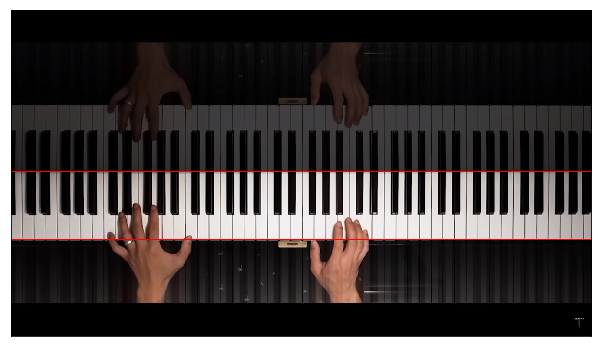

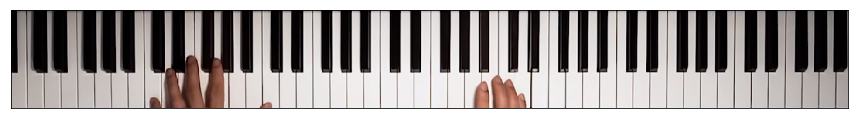

In [3]:
img_id = 1
img_name = "piano{}.png".format(img_id)
image = cv2.imread(img_name)
(h, w, c) = image.shape

# Marcar corte
hi, hf = [(535, 760), (548, 804), (520, 784)][img_id - 1]

cropped_preview = image.copy()
cv2.line(cropped_preview, (0, hi), (w-1, hi), (0, 0, 255), 3)
cv2.line(cropped_preview, (0, hf), (w-1, hf), (0, 0, 255), 3)

image_plot(cv2.cvtColor(cropped_preview, cv2.COLOR_BGR2RGB))

cropped = image[hi:hf,:,:]

image_plot(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

# Tratar imagem para escala de cinza

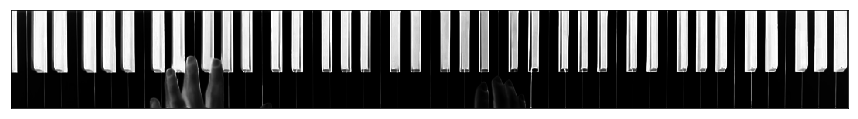

In [4]:
# Multiplicar as componentes R, G e B invertidas
gsimg = (255 - cropped).prod(axis=2).astype('float32')

# Multiplicar pelo menor valor entre R, G e B invertidos
gsimg *= np.amin((255 - cropped), axis=2)

# Normalizer resultado entre 0 a 255
gsimg = ((gsimg * 255) / gsimg.max()).astype('uint8')

image_plot(cv2.cvtColor(gsimg, cv2.COLOR_GRAY2RGB))

# Binarizar a imagem para achar as teclas

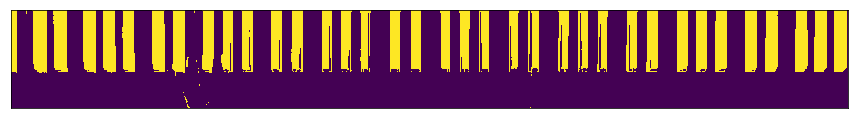

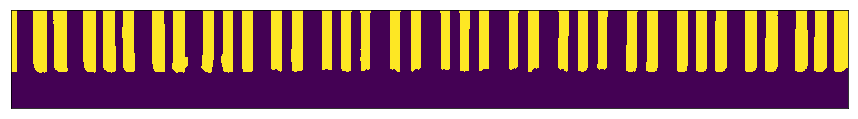

In [12]:
(hh, ww) = gsimg.shape

# Criar um buffer branco
teste = np.ones((hh * 2, ww)) * 255
teste[0:hh,:] = gsimg
teste = teste.astype('uint8')

# Binarização por Otsu
ret, thresh = cv2.threshold(teste, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
thresh = thresh[0:hh,:]
image_plot(thresh)

kernel_size = int(cropped.shape[1] * 0.005)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

# Morfologia para fechar buracos
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
# Morfologia para tirar ruído
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

image_plot(thresh)

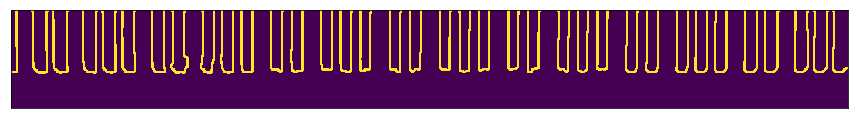

In [13]:
edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
image_plot(cv2.dilate(edges, np.ones((5,5))))

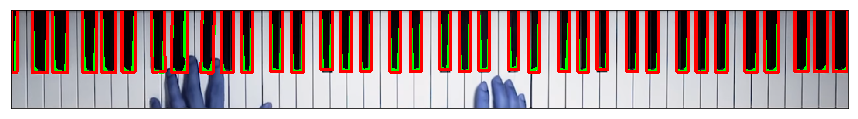

In [14]:
quero = cropped.copy()
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    #approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)
    approx = cv2.approxPolyDP(cnt, 4, True)
    
    xi,yi,wi,hi = cv2.boundingRect(cnt)
    
    #cv2.rectangle(quero, (xi,yi), (xi+wi,yi+hi), (0,0,255), 5)
    cv2.drawContours(quero, [approx], 0, (0,255,0), 5)

    
    
    box = cv2.boxPoints(cv2.minAreaRect(cnt))
    cv2.drawContours(quero, [np.intp(box)], 0, (255,0,0), 5)
    
num_keys = len(contours)

image_plot(quero)

Ponto 1(-1932,141) -> Ponto 2(1931,142)


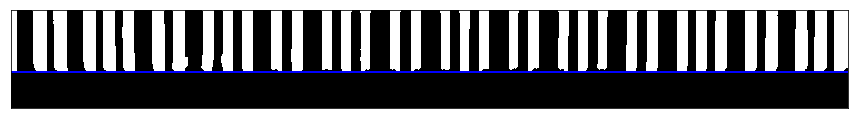

In [15]:
hough = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

# Achar o fim das teclas pretas
limit_black_keys = cropped.shape[0]/2

# Hough para pegar linhas totalmente horizontais ou verticais
lines = cv2.HoughLines(edges, 1, np.pi / 2, int(cropped.shape[1] * 0.1))

# Tamanho da diagonal da imagem
maxsize = int(np.sqrt(cropped.shape[0] ** 2 + cropped.shape[1] ** 2))

if lines is not None:
    for line in lines:
        rho, theta = line[0]

        if not (np.pi * 3/4 >= (theta % np.pi) >= np.pi * 1/4):
            continue

        a, b = np.cos(theta), np.sin(theta)

        x0, y0 = a * rho, b * rho

        x1, y1 = int(x0 + maxsize * (-b)), int(y0 + maxsize * (a))
        x2, y2 = int(x0 - maxsize * (-b)), int(y0 - maxsize * (a))

        # Desenhar
        cv2.line(hough, (x1, y1), (x2, y2), (0, 0, 255), 3)
        print("Ponto 1({},{}) -> Ponto 2({},{})".format(x1,y1,x2,y2))
        
        # Salvar esse novo limite
        limit_black_keys = min(y1, y2)
        
        break # Desenhar só uma linha

image_plot(hough)

Ponto 1(553,1932) -> Ponto 2(553,-1932)
Ponto 1(621,1932) -> Ponto 2(621,-1932)
Ponto 1(915,1932) -> Ponto 2(915,-1932)
Ponto 1(668,1932) -> Ponto 2(668,-1932)
Ponto 1(1072,1932) -> Ponto 2(1072,-1932)
Ponto 1(892,1932) -> Ponto 2(892,-1932)
Ponto 1(1526,1932) -> Ponto 2(1526,-1932)
Ponto 1(779,1932) -> Ponto 2(779,-1932)
Ponto 1(1095,1932) -> Ponto 2(1095,-1932)
Ponto 1(868,1932) -> Ponto 2(868,-1932)
Ponto 1(1140,1932) -> Ponto 2(1140,-1932)
Ponto 1(1028,1932) -> Ponto 2(1028,-1932)
Ponto 1(1595,1932) -> Ponto 2(1595,-1932)
Ponto 1(1640,1932) -> Ponto 2(1640,-1932)
Ponto 1(1709,1932) -> Ponto 2(1709,-1932)
Ponto 1(735,1932) -> Ponto 2(735,-1932)
Ponto 1(1482,1932) -> Ponto 2(1482,-1932)
Ponto 1(823,1932) -> Ponto 2(823,-1932)
Ponto 1(984,1932) -> Ponto 2(984,-1932)
Ponto 1(1551,1932) -> Ponto 2(1551,-1932)
Ponto 1(1757,1932) -> Ponto 2(1757,-1932)
Ponto 1(210,1932) -> Ponto 2(210,-1932)
Ponto 1(1344,1932) -> Ponto 2(1344,-1932)
Ponto 1(711,1932) -> Ponto 2(711,-1932)
Ponto 1(755,1932

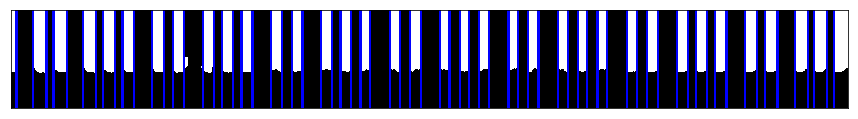

In [16]:
hough = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

# Achar o fim das teclas pretas
limit_black_keys = cropped.shape[0]/2

# Hough para pegar linhas totalmente horizontais ou verticais
lines = cv2.HoughLines(edges, 1, np.pi / 32, int(cropped.shape[0] * 0.25))

# Tamanho da diagonal da imagem
maxsize = int(np.sqrt(cropped.shape[0] ** 2 + cropped.shape[1] ** 2))

iter = 0

if lines is not None:
    for line in lines:
        
        if iter > num_keys * 3:
            pass
        iter += 1
        
        rho, theta = line[0]

        if (np.pi * 3/4 >= (theta % np.pi) >= np.pi * 1/4):
            continue

        a, b = np.cos(theta), np.sin(theta)

        x0, y0 = a * rho, b * rho

        x1, y1 = int(x0 + maxsize * (-b)), int(y0 + maxsize * (a))
        x2, y2 = int(x0 - maxsize * (-b)), int(y0 - maxsize * (a))

        # Desenhar
        cv2.line(hough, (x1, y1), (x2, y2), (0, 0, 255), 3)
        print("Ponto 1({},{}) -> Ponto 2({},{})".format(x1,y1,x2,y2))

image_plot(hough)

In [10]:
# Ransac